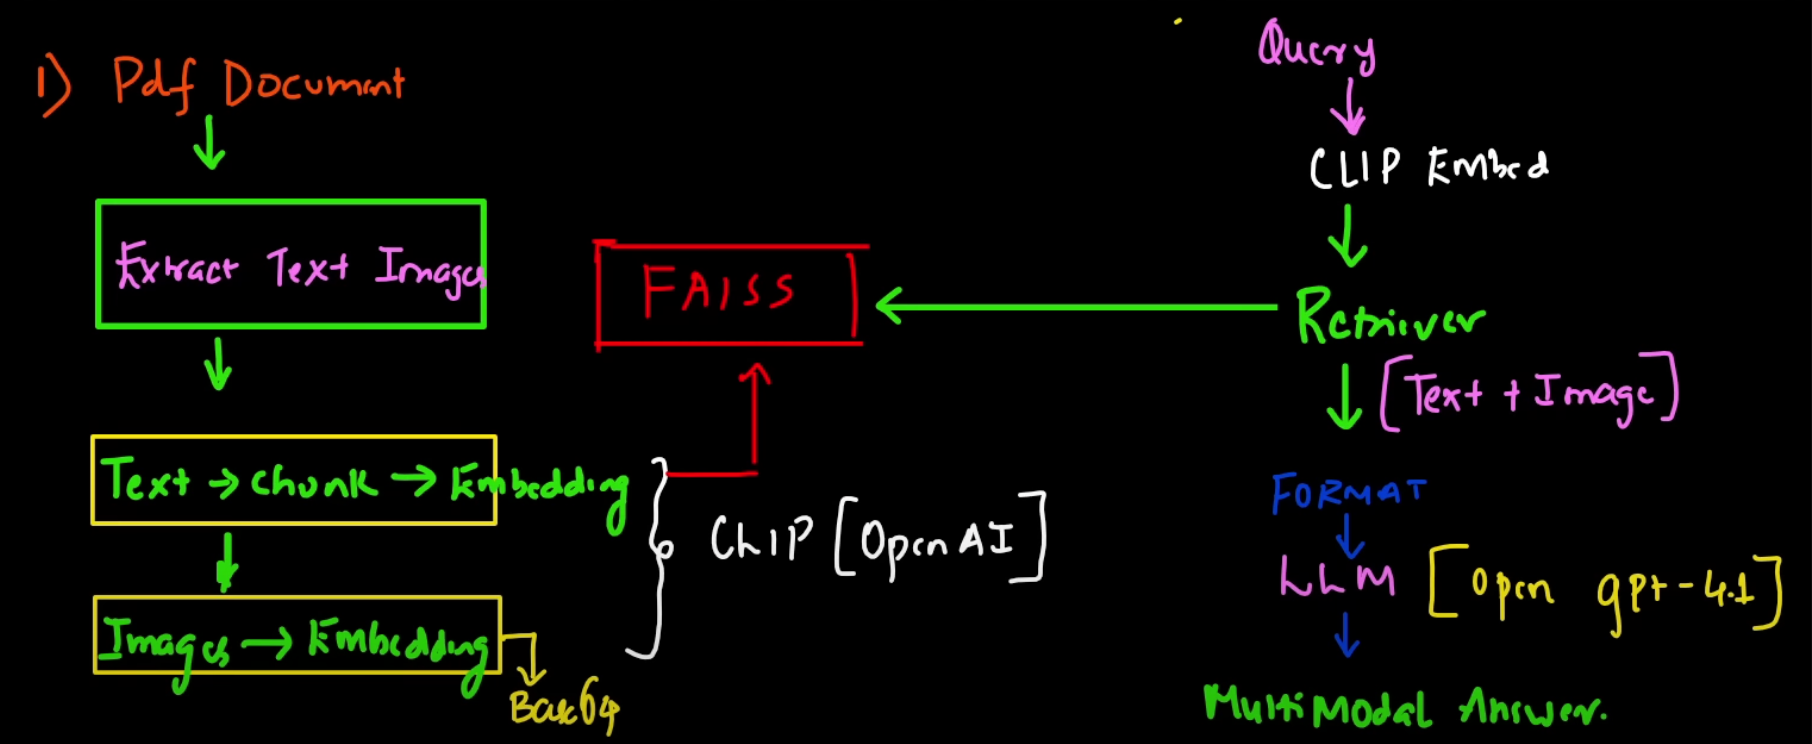

In [1]:
# Display the screenshot
from IPython.display import Image, display

# Display the screenshot
image_path = "Screenshot 2025-08-02 at 13.13.13.png"
display(Image(filename=image_path))

In [ ]:
# Install required packages
!pip install pymupdf langchain-community langchain-core transformers torch pillow faiss-cpu sentence-transformers

In [4]:
import fitz  # PyMuPDF
from langchain_core.documents import Document
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch
import numpy as np
from langchain.chat_models import init_chat_model
from langchain.prompts import PromptTemplate
from langchain.schema.messages import HumanMessage
from sklearn.metrics.pairwise import cosine_similarity
import os
import base64
import io
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS

In [5]:
###Clip Model
import os
from dotenv import load_dotenv
load_dotenv()

## set up the environment
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

### initialize the Clip Model for unified embeddings
clip_model=CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor=CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model.eval()

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [6]:
### Embedding functions
def embed_image(image_data):
    """Embed image using CLIP"""
    if isinstance(image_data, str):  # If path
        image = Image.open(image_data).convert("RGB")
    else:  # If PIL Image
        image = image_data
    
    inputs=clip_processor(images=image,return_tensors="pt")
    with torch.no_grad():
        features = clip_model.get_image_features(**inputs)
        # Normalize embeddings to unit vector
        features = features / features.norm(dim=-1, keepdim=True)
        return features.squeeze().numpy()

In [7]:
def embed_text(text):
    """Embed text using CLIP."""
    inputs = clip_processor(
        text=text, 
        return_tensors="pt", 
        padding=True,
        truncation=True,
        max_length=77  # CLIP's max token length
    )
    with torch.no_grad():
        features = clip_model.get_text_features(**inputs)
        # Normalize embeddings
        features = features / features.norm(dim=-1, keepdim=True)
        return features.squeeze().numpy()

In [8]:
## Process PDF
pdf_path="multimodal_sample.pdf"
doc=fitz.open(pdf_path)
# Storage for all documents and embeddings
all_docs = []
all_embeddings = []
image_data_store = {}  # Store actual image data for LLM

# Text splitter
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)

In [9]:
doc

Document('multimodal_sample.pdf')

In [10]:
for i,page in enumerate(doc):
    ## process text
    text=page.get_text()
    if text.strip():
        ##create temporary document for splitting
        temp_doc = Document(page_content=text, metadata={"page": i, "type": "text"})
        text_chunks = splitter.split_documents([temp_doc])

        #Embed each chunk using CLIP
        for chunk in text_chunks:
            embedding = embed_text(chunk.page_content)
            all_embeddings.append(embedding)
            all_docs.append(chunk)



    ## process images
    ##Three Important Actions:

    ##Convert PDF image to PIL format
    ##Store as base64 for GPT-4V (which needs base64 images)
    ##Create CLIP embedding for retrieval

    for img_index, img in enumerate(page.get_images(full=True)):
        try:
            xref = img[0]
            base_image = doc.extract_image(xref)
            image_bytes = base_image["image"]
            
            # Convert to PIL Image
            pil_image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
            
            # Create unique identifier
            image_id = f"page_{i}_img_{img_index}"
            
            # Store image as base64 for later use with GPT-4V
            buffered = io.BytesIO()
            pil_image.save(buffered, format="PNG")
            img_base64 = base64.b64encode(buffered.getvalue()).decode()
            image_data_store[image_id] = img_base64
            
            # Embed image using CLIP
            embedding = embed_image(pil_image)
            all_embeddings.append(embedding)
            
            # Create document for image
            image_doc = Document(
                page_content=f"[Image: {image_id}]",
                metadata={"page": i, "type": "image", "image_id": image_id}
            )
            all_docs.append(image_doc)
            
        except Exception as e:
            print(f"Error processing image {img_index} on page {i}: {e}")
            continue

doc.close()

In [11]:
all_docs

[Document(metadata={'page': 0, 'type': 'text'}, page_content='Annual Revenue Overview\nThis document summarizes the revenue trends across Q1, Q2, and Q3. As illustrated in the chart\nbelow, revenue grew steadily with the highest growth recorded in Q3.\nQ1 showed a moderate increase in revenue as new product lines were introduced. Q2 outperformed\nQ1 due to marketing campaigns. Q3 had exponential growth due to global expansion.'),
 Document(metadata={'page': 0, 'type': 'image', 'image_id': 'page_0_img_0'}, page_content='[Image: page_0_img_0]')]

In [12]:
# Create unified FAISS vector store with CLIP embeddings
embeddings_array = np.array(all_embeddings)
embeddings_array


array([[-0.0026724 ,  0.0128299 , -0.05183144, ..., -0.0038509 ,
         0.02977725, -0.00010685],
       [ 0.0173236 , -0.01327708, -0.02427027, ...,  0.0899398 ,
        -0.00272157,  0.03253057]], shape=(2, 512), dtype=float32)

In [13]:
(all_docs,embeddings_array)

([Document(metadata={'page': 0, 'type': 'text'}, page_content='Annual Revenue Overview\nThis document summarizes the revenue trends across Q1, Q2, and Q3. As illustrated in the chart\nbelow, revenue grew steadily with the highest growth recorded in Q3.\nQ1 showed a moderate increase in revenue as new product lines were introduced. Q2 outperformed\nQ1 due to marketing campaigns. Q3 had exponential growth due to global expansion.'),
  Document(metadata={'page': 0, 'type': 'image', 'image_id': 'page_0_img_0'}, page_content='[Image: page_0_img_0]')],
 array([[-0.0026724 ,  0.0128299 , -0.05183144, ..., -0.0038509 ,
          0.02977725, -0.00010685],
        [ 0.0173236 , -0.01327708, -0.02427027, ...,  0.0899398 ,
         -0.00272157,  0.03253057]], shape=(2, 512), dtype=float32))

In [14]:
# Create custom FAISS index since we have precomputed embeddings
vector_store = FAISS.from_embeddings(
    text_embeddings=[(doc.page_content, emb) for doc, emb in zip(all_docs, embeddings_array)],
    embedding=None,  # We're using precomputed embeddings
    metadatas=[doc.metadata for doc in all_docs]
)
vector_store

`embedding_function` is expected to be an Embeddings object, support for passing in a function will soon be removed.


In [15]:
# Initialize GPT-4 Vision model
llm = init_chat_model("openai:gpt-4.1")
llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x16b9df860>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x16d09f9b0>, root_client=<openai.OpenAI object at 0x104942ab0>, root_async_client=<openai.AsyncOpenAI object at 0x16d013fe0>, model_name='gpt-4.1', model_kwargs={}, openai_api_key=SecretStr('**********'))

In [16]:
def retrieve_multimodal(query, k=5):
    """Unified retrieval using CLIP embeddings for both text and images."""
    # Embed query using CLIP
    query_embedding = embed_text(query)
    
    # Search in unified vector store
    results = vector_store.similarity_search_by_vector(
        embedding=query_embedding,
        k=k
    )
    
    return results

In [17]:
def create_multimodal_message(query, retrieved_docs):
    """Create a message with both text and images for GPT-4V."""
    content = []
    
    # Add the query
    content.append({
        "type": "text",
        "text": f"Question: {query}\n\nContext:\n"
    })
    
    # Separate text and image documents
    text_docs = [doc for doc in retrieved_docs if doc.metadata.get("type") == "text"]
    image_docs = [doc for doc in retrieved_docs if doc.metadata.get("type") == "image"]
    
    # Add text context
    if text_docs:
        text_context = "\n\n".join([
            f"[Page {doc.metadata['page']}]: {doc.page_content}"
            for doc in text_docs
        ])
        content.append({
            "type": "text",
            "text": f"Text excerpts:\n{text_context}\n"
        })
    
    # Add images
    for doc in image_docs:
        image_id = doc.metadata.get("image_id")
        if image_id and image_id in image_data_store:
            content.append({
                "type": "text",
                "text": f"\n[Image from page {doc.metadata['page']}]:\n"
            })
            content.append({
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/png;base64,{image_data_store[image_id]}"
                }
            })
    
    # Add instruction
    content.append({
        "type": "text",
        "text": "\n\nPlease answer the question based on the provided text and images."
    })
    
    return HumanMessage(content=content)

In [18]:
def multimodal_pdf_rag_pipeline(query):
    """Main pipeline for multimodal RAG."""
    # Retrieve relevant documents
    context_docs = retrieve_multimodal(query, k=5)
    
    # Create multimodal message
    message = create_multimodal_message(query, context_docs)
    
    # Get response from GPT-4V
    response = llm.invoke([message])
    
    # Print retrieved context info
    print(f"\nRetrieved {len(context_docs)} documents:")
    for doc in context_docs:
        doc_type = doc.metadata.get("type", "unknown")
        page = doc.metadata.get("page", "?")
        if doc_type == "text":
            preview = doc.page_content[:100] + "..." if len(doc.page_content) > 100 else doc.page_content
            print(f"  - Text from page {page}: {preview}")
        else:
            print(f"  - Image from page {page}")
    print("\n")
    
    return response.content

In [19]:
if __name__ == "__main__":
    # Example queries
    queries = [
        "What does the chart on page 1 show about revenue trends?",
        "Summarize the main findings from the document",
        "What visual elements are present in the document?"
    ]
    
    for query in queries:
        print(f"\nQuery: {query}")
        print("-" * 50)
        answer = multimodal_pdf_rag_pipeline(query)
        print(f"Answer: {answer}")
        print("=" * 70)


Query: What does the chart on page 1 show about revenue trends?
--------------------------------------------------

Retrieved 2 documents:
  - Text from page 0: Annual Revenue Overview
This document summarizes the revenue trends across Q1, Q2, and Q3. As illust...
  - Image from page 0


Answer: The chart on page 1 shows that revenue increased steadily across the first three quarters of the year. Q1 (blue bar) had the lowest revenue, Q2 (green bar) saw higher revenue than Q1, and Q3 (red bar) had the highest revenue by a significant margin. This visual trend matches the text, which notes moderate growth in Q1, greater growth in Q2 due to marketing, and sharp, exponential growth in Q3 as a result of global expansion. Overall, the revenue trend is consistently upward, with the fastest growth occurring in Q3.

Query: Summarize the main findings from the document
--------------------------------------------------

Retrieved 2 documents:
  - Text from page 0: Annual Revenue Overview
This d